In [1]:
### PREAMBLE
# Intro to machine learning
# scatter_fit_title.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Machine Learning

This lecture transition to the next unit in this course.  Whereas the previous lectures have largely been about data processing (how we obtain, store, and operate upon different types of data you're likely to encounter in data science tasks), this lecture will mark a shift to the question of analysis: how do we make predictions about and analyze the data we have collected?  We have already seen a little bit of this in the context of free text processing, but this lecture will shift even more to this question, starting with the topic of machine learning.

Machine learning is a fast-growing field at the current time, though we should emphasize that the initial techniques we're going to cover here (namely linear regression) pre-date the term by about 200 years (Gauss is typically credited for developing least squares regression in around 1800).  And much of the later techniques we talk about were well-studied in statistics in the early part of the century.  We're still going to use the general term machine learning to cover all these, but it is important to know that these ideas did not start with the ML community.  Rather, machine learning as a topic has grown due to the combination of three different elements: 1) gains in computing power (machine learning, as it grew out of computer science, has always been fundamentally concerned with computational algorithms), 2) massive amounts of available data (the "raw materials" for machine learning methods), and 3) some notable algorithmic advances that have occurred over the last 30 years.  To start, though, we're going to cover some of the most basic algorithms to codify the underlying principles.

## Introduction to machine learning

Machine learning, at its core, is a data driven way to write program.  Let's
say (and this isn't entirely hypothetical, as this task is now so common a benchmark in machine learning that it has become passe), you want to write a program that can
classify one of following images as a digit between 0 and 9:

![Images of digits from the MNIST dataset, a benchmark machine learning task.](digits.png)

The "traditional" way of writing a program like this is to think logically about
what short of distinguishing characteristics make up each digit, codify this
logic as a computer program, and then write it down (probably iterating as
necessary when you find that your logic didn't work for some cases).  This
general programming technique (if you could even call it that, as it is
typically just part of what we think about when we think of writing comptuer
programs) has proven extremely useful in many situations, but it also can prove
exceptionally difficult in some cases, including the image case above.  The idea
of identifying digits seems "easy" to us, but for a computer program, these
images are just 28x28 collections of pixels, and writing code that can express
high-level concepts like the general "shape" of a character is quite challenge.

The machine learning approach to a problem like this, in contrast, is the
following.  Instead of attempting to manually construct a program that produces
image classifications from pixels, we collect a \emph{data set} that consists of
a large number of images and their corresponding labels, then use a machine
learning algorithm to _automatically_ learn a kind of "program" that can produce
these correct classifications on the data set that we have.  We use the term
"program" here because, although the resulting classifier is not what we typically think
of as a program (ML "programs" usually consist of simple parameterized functions of a
particular form) it conceptually acts in the same manner. Strictly
speaking, the process described here (where we provide the algorithm both the
inputs and the target labels) is actually a subclass of machine learning
known as "supervised learning", but the same ideas we introduce below actually
also apply surprisngly similarly to the so-called unsupervised learning setting,
which we will discuss later.

### Example: predicting peak electrical power

Let's consider the above problem a bit more formally, staring with a simple
example.  Suppose you want to predict what the peak electricity demand will be
during the day tomorrow for some area (we'll consider data from the area
surrounding Pittsburgh, PA).  This is actually a very important problem from a
logitics planning perspective: electricity generators, which for the most part
are based upon boiling water to move turbines, cannot turn on instantly, so in
order to guarantee that we have enough power to supply a given area, a system
operator typically needs to have some excess generation always waiting in the
wings.  The better we can forecast future demand, the smaller our excess margin
can be, leading to increased efficiency of the entire electrical grid.  
The power consumption tomorrow depends on many factors: temperature, day of
week, season, holiday events, etc, not to mention some inherrent randomness
that we don't expect to even predict with perfect accuracy.  However, even for
someone working in the area, it would be very
difficult to come up with a model for electrical demand based soley upon "first
principles", thinking about the nature of electricity consumption or the devices
people may use, in an attempt to predict future consumption.

What _is_ easy, however, is simply to collect lots of data about past energy
consumption (the system operator serving the Pittsburgh region, PJM, maintains
a data set available [here](http://www.pjm.com/markets-and-operations/ops-analysis/historical-load-data.aspx)) 
as well as the past factors that affect consumption, like the past weather for
the area (which can be easily downloaded from the [WeFacts](http://wefacts.org) site we mentioned earlier).  Since this is a data science course, and since we've already covered the data collection process, let's be very explicit, and show the data collection process.  Specifically, we downloaded the `201X-hourly-loads.xls` files for 2013-2017, and the weather for Pittsburgh from 2013-2017 (in the `kpit_weather.csv` file).  The files we are loading are the raw files we downloaded from these two sites, with no preprocessing.  We can load and plot the data with the following code.

In [48]:
# New URL https://dataminer2.pjm.com/feed/hrl_load_estimated
# load all electrical demand data
df_load = pd.concat([pd.read_csv(filename, index_col=None, header=0)
                        for filename in glob.glob("pjm_load_data/*.csv")], 
                    ignore_index=True)
# reformat the date to a compatibile form
df_load["datetime_beginning_utc"] = df_load["datetime_beginning_utc"].apply(lambda x: str(pd.to_datetime(x).strftime('%Y/%m/%d')).replace("/","")[:8])
# get the peak demands for each day
df_load_new = df_load.groupby("datetime_beginning_utc").max()[["estimated_load_hourly"]]

In [50]:
df_load.head()

,datetime_beginning_utc,datetime_beginning_ept,datetime_ending_utc,datetime_ending_ept,load_area,estimated_load_hourly
0,20170101,1/1/2017 12:00:00 AM,1/1/2017 6:00:00 AM,1/1/2017 1:00:00 AM,DUQ,1370
1,20170101,1/1/2017 1:00:00 AM,1/1/2017 7:00:00 AM,1/1/2017 2:00:00 AM,DUQ,1336
2,20170101,1/1/2017 2:00:00 AM,1/1/2017 8:00:00 AM,1/1/2017 3:00:00 AM,DUQ,1312
3,20170101,1/1/2017 3:00:00 AM,1/1/2017 9:00:00 AM,1/1/2017 4:00:00 AM,DUQ,1288
4,20170101,1/1/2017 4:00:00 AM,1/1/2017 10:00:00 AM,1/1/2017 5:00:00 AM,DUQ,1286


In [51]:
df_load_new.head()

,estimated_load_hourly
datetime_beginning_utc,
20130101,1846
20130102,2044
20130103,2054
20130104,2022
20130105,1976


In [52]:
# load weather and get maximum by day
df_weather = pd.read_csv("kpit_weather.csv")
df_weather = df_weather[df_weather["Time"] != -9999]
df_weather["Date"] = df_weather["Time"].apply(lambda x: str(x)[:8])
df = df_weather.groupby("Date").max()[["OAT"]]
df["Temp"] = df["OAT"].apply(lambda x : x/10. * (9/5) + 32)

df_weather.head()

,ZTime,Time,OAT,DT,SLP,WD,WS,SKY,PPT,PPT6,Plsr.Event,Plsr.Source,Date
0,20130101050000,20130101000000,0,-28,10180,250,46,8,3,-9999,NaN,NaN,20130101
1,20130101060000,20130101010000,0,-22,10175,260,31,8,-1,-9999,NaN,NaN,20130101
2,20130101070000,20130101020000,-6,-22,10175,260,41,8,-1,-9999,NaN,NaN,20130101
3,20130101080000,20130101030000,-6,-17,10175,240,21,8,-1,-9999,NaN,NaN,20130101
4,20130101090000,20130101040000,-6,-17,10173,250,26,8,-1,-9999,NaN,NaN,20130101


In [53]:
df.head()

,OAT,Temp
Date,,
20130101,0,32.00
20130102,-39,24.98
20130103,6,33.08
20130104,0,32.00
20130105,17,35.06


In [96]:
# join with load, then get just summer methods
df["Load"] = pd.Series(df_load_new["estimated_load_hourly"].values/1000, index=df.index)
df_summer = df[list(map(lambda x : x[4:6] in ["06", "07", "08"], df.index))].copy()
df_summer.head()

,OAT,Temp,Load
Date,,,
20130601,294,84.92,2.299
20130602,267,80.06,2.160
20130603,206,69.08,1.927
20130604,222,71.96,1.827
20130605,267,80.06,2.109


Text(0, 0.5, 'Peak Demand (GW)')

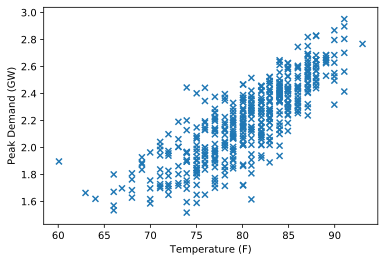

In [55]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

As it turns out, electricity consumption in the summer in Pittsburgh is largely
driven by air conditioning, so with increasing high temperature comes increasing
electrical demand.  Thus, we may hypothesize that we can form a fairly good prediction of the peak demand using a linear model: that is, we hypothesize that 
\begin{equation}
\mathrm{PeakDemand} \approx \theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
where $\theta_1$ is the slope of the line and $\theta_2$ is the intercept term (together called the _parameters_ of the model).  For example, just eyeballing the data we might guess that the slope is $\theta_1 = 0.05$ (we get an increase of 0.05 GW per degree F, which we just arrived at by seeing that the power increased, very apprximately, by noticing a total of ~1 GW increase in the range of 70 to 90 degree).  If we further suppose that the average demand is about 2.1GW at 80 degrees F, then we can solve for the intercept term by $0.05*80 + \theta_2 = 2.1$, or $\theta_2 = -1.9$.  Note: if this seems ad-hoc to you, don't worry, it is!  We will shortly decribe to to actually find good values for these parameters in a disciplined way.

(58.42314336917561, 94.67685663082436) (1.4301233995584988, 3.0378766004415008)


Text(0, 0.5, 'Peak Demand (GW)')

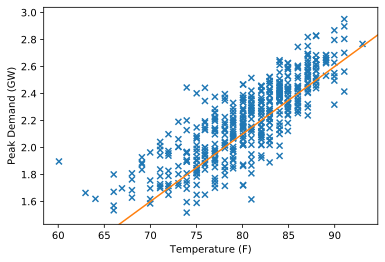

In [101]:
theta = np.array([0.05, -1.9])
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
print(xlim, ylim)
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

Naturally, this model won't fit the data exactly (we can see from the
chart that the figure doesn't lie precisely on an exact line), but if we can
find slope and intercept terms that fit the data well, then for example, if we
want to know what the peak demand will be tomorrow we can simply plug in the
forecasted high temperature into the equation above get an estimate of the peak
demand tomorrow (ignore the fact, for now
that the high temperature tomorrow is also a prediction, we'll assume we just
get this from a reliable source, and domains like weather forecasting are
extremely well-studied in practice).  This is of course equivalent to just "finding a point on the line".

### Finding good parameters

The question, of course, is how we find "good" values for $\theta_1$ and $\theta_2$ that fit this data well, i.e., so that the line fits the data as "closely" as possible.  The method we will describe for doing this (which is called _gradient descent_) is probably not the simplest algorithm for finding this fit.  In fact, as we will see, there is a very simple closed-form expression that will immediately give us the same solution for the framework we consider here.  But gradient descent is an _extremely_ powerful and general algorithm (and _is_ actually quite simple compared to some alternative approaches), and it is no exaggeration to say that gradient descent underlies virtually all modern machine learning.  So, with these caveats in place, let's dive in to understanding how we find "good" parameters $\theta_1$ and $\theta_2$ in some disciplined manner.

**Objective functions**  In order to find good values for the parameters, we need to formally define what "good" means in this setting.  This will actually be one of the key questions for machine learning algorithms in general, and difference notions of goodness lead to different algorithms.  Fortunately, there are some very well-studied definitions in this context, and so we have some "standard" options that we can try.  The notion that we will consider here captures the idea of the "squared error" between the prediction and the actual values.  That is, we consider all the days in the plot above, where $\mathrm{HighTemperature}^{(i)}$ denotes the high temperature and $\mathrm{PeakDemand}^{(i)}$ denotes the peak demand on day $i$.  Since _predicted_ peak demand for day $i$ is equal to
\begin{equation}
\theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
we want to make this quantity as close as possible, averaged over all the days, to the true $\mathrm{PeakDemand}^{(i)}$.  We're going to measure this closeness in terms of the squared difference between the predicted and actual more.  More formally, we would like to minimize the quantity:
\begin{equation}
\frac{1}{\# \mathrm{days}} \sum_{i \in \mathrm{days}} \left ( \theta_1 \cdot \mathrm{HighTemperature}^{(i)} + \theta_2 - \mathrm{PeakDemand}^{(i)} \right )^2 \equiv E(\theta)
\end{equation}
which we abbreviate as $E(\theta)$ to emphasize the fact that we are going to be minimizing this error by tuning our $\theta$ variables.  This is known as the _objective function_ that we are trying to minimize.  A natural question that you may be asking is: why did we choose to measure closeness using this squared difference?  Why not use the average of absolute difference?  Or the maximum absolute difference?  These are good questions, and we'll defer answering them for now, except to say that we will definitely consider other possibilities later.  The squared error is simply a very common choice, mainly for reasons of mathematical convenience.

**Minimizing the objective** How do we go about finding the values of $\theta_1$ and $\theta_2$ that minimize $E(\theta)$?  There are several ways to do this, but we'll consider one here based upon the notion of derivatives from calculus.  Recall that for a scalar function $f : \mathbb{R} \rightarrow \mathbb{R}$, the derivative of the function, denoted $f'$ provides the _slope_ of the function at any point).
![Illustration of a function and it's derivative.](opt_grad.svg)
In this figure, for regions on the left of the plot, the slope is negative, while on the right of the plot, the slope is positive.  Thus, if we want to minimize the function, and we begin at some point $\theta^{(0)}$, it makes sense to update this point by modifying it in the direction of the _negative_ dervative.  This simple intuition for the basis for the gradient descent algorithm.

**Note: Partial derivatives** As mentioned above, for scalar functions $f : \mathbb{R} \rightarrow \mathbb{R}$, we denote the derivative as $f'$ (also a scalar function $f' : \mathbb{R} \rightarrow \mathbb{R}$.  However, for vector-input functions, this notation becomes imprecise: it is not clear _which_ of the various derivatives we are taking.  For this reason, when we discuss derivatives of functions that take vectors as inputs, we use the notation of _partial_ derviatives.  The partial derivative of a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ with respect to the $j$th coordinate of the input vector, denoted
\begin{equation}
\frac{\partial f(\theta)}{\partial \theta_j}
\end{equation}
is just the derivative of $f$ with respect to $\theta_j$, _treating all other coordinates at constants_.  So for example for the function $f : \mathbb{R}^2 \rightarrow \mathbb{R}$
\begin{equation}
f(\theta) = \theta_1 \cdot \theta_2 + 3 \theta_1 - \theta_2
\end{equation}
then the partial derivatives are given by
\begin{equation}
\begin{split}
\frac{\partial f(\theta)}{\partial \theta_1} & = \theta_2 + 3 \\
\frac{\partial f(\theta)}{\partial \theta_2} & = \theta_1 - 1
\end{split}
\end{equation}
which is simply the derivative with respect to each of $\theta_1$ and $\theta_2$, treating the other term as a constant value.

### The gradient descent algorithm (first pass)

Extending our intuition above, the gradient descent algorithm for multivariate functions is intuitively just as simple as in the scalar case: we simply repeatedly take small steps in the derivative of the _negative partial derivatives_, for _each coordinate of our parameters_.  To see what this looks like, let's compute the partial derivatives with respect to $E(\theta)$ (our sum of squared error), with respect to $\theta_1$ and $\theta_2$.  The _only_ properties we will use here are:

1. Basic facts about the derivative of polynomials, i.e., that for $f(x) = x^2$, $f'(x) = 2x$.
2. The chain rule, that for $h(x) = f(g(x))$, $h'(x) = f'(g(x))g'(x)$
3. Linearity of the derivative, the fact that for $f(x) = \sum_i f_i(x)$, $f'(x) = \sum_i f_i'(x)$


In fact, other than the fact that the notation gets trickier when you have matrices and vectors, these are just about the only rules you need to derive most modern machine learning algorithms.  Let's also standardize our notation a bit by refering to $\mathrm{HighTemperature}^{(i)}$ just as $x^{(i)} \in \mathbb{R}$ (the $x$ notation comes from the fact that these are the "inputs" to our prediction model), and $\mathrm{PeakDemand}^{(i)}$ as $y^{(i)} \in \mathbb{R}$ (similarly, $y$ denoting the fact that this is the "output" of our prediction model).  We will also index each day as a number between 1 and $m$, where here $m$ will represent the total number of days.  Thus, we can rewrite our optimization objective as
\begin{equation}
E(\theta) = \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2.
\end{equation}
Let's compute the partial derivatives of this function with respect to $\theta_1$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_1} & = \frac{\partial}{\partial \theta_1} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_1} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_1} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)}
\end{split}
\end{equation}
where in the second line we use the linearity of the derivative, in the third line we use the chain rule and the above fact about differentating a polynomial, and in the fourth line we use the fact that all the terms except $\theta_1 \cdot x^{(i)}$ are "constants" in terms of differentiating with respect to $\theta_1$.  Using the exact same logic, we can also compute the partial derivative with respect to $\theta_2$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_2} & = \frac{\partial}{\partial \theta_2} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_2} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_2} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )
\end{split}
\end{equation}
where all the derivatives proceed identically except for the fact that the coefficient term multiplying $\theta_2$ in the last equation is always equal to 1, so the equation has no $x^{(i)}$ term on the outside.  This leads to the gradient descent step for our setting, where we initialize $\theta_1$ and $\theta_2$ to some value (usually simply zero), and repeat the updates:
\begin{equation}
\begin{split}
\theta_1 & := \theta_1 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)} \\
\theta_2 & := \theta_2 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \\
\end{split}
\end{equation}
where $\alpha$ is some small positive constant (indicating how big of a step in the direction of the negative gradient we take), called the _step size_.  We'll discuss the step size more shortly.  Note that we can also remove the "2" constant as this can just be incorporated into the step size.

**Data normalization**  We'll shortly see what the gradient descent procedure looks like in our example above.  Before we apply the algorithm, though, we're going to make one small modification to our problem, and _normalize_ the data (both the inputs and the output) before we attempt to run the gradient descent algorithm.  We will see the reason for this more clearly shortly, but the brief reason is that if our slope and intercept terms are on very different "scales" (which would be the case here, because of the relatively large input values (units of degrees Farenheit) compared to the output values (units of gigawatts)), then we would actually need to take very different step sizes in the two parameters $\theta_1$ and $\theta_2$.  This is possible to manually tune in our case, but when we start having many more parameters, it's not feasible.  We thus make our life much easier if we scale all the input and output data to be in the same rough range _before_ running gradient descent (Note: in class I talked about only scaling the input, which also happens to work fine here, but I think it may be easier conceptually to consider the case where we just normalize all the inputs and outputs in the same manner).

We can normalize data in a number of ways, but a simple strategy is just to translate and scale the coordinates such that the values vary between zero and one in our dataset.  This can be easily achieved by the transformation
\begin{equation}
\tilde{x}^{(i)} = \frac{x^{(i)} - \min_i x^{(i)}}{\max_i x^{(i)} - \min_i x^{(i)}}
\end{equation}
and similarly for $\tilde{y}^{(i)}$.  Let's normalize our temperature/demand data and see what this looks like.

Text(0, 0.5, 'Normalized Demand')

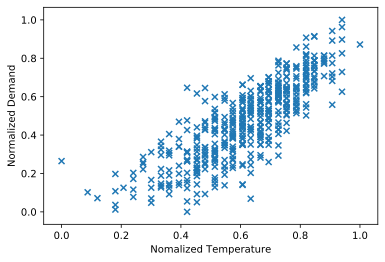

In [57]:
x = df_summer["Temp"].values
y = df_summer["Load"].values
x_nor = (x - min(x)) / (max(x) - min(x))
y_nor = (y - min(y)) / (max(y) - min(y))
plt.scatter(x_nor, y_nor, marker = 'x')
plt.xlabel("Nomalized Temperature")
plt.ylabel("Normalized Demand")

This look identical to the previous plot, of course, except that the units no longer correspond to traditional quantities like degrees Fahrenheit or gigawatts, but just some linear transformation of these units.

### Visualizing gradient descent

Now let's look at the gradient descent algorithm.  This will initialize $\theta_1$ and $\theta_2$ to zero and repeatedly update them according to the partial derivative rules.  We will use the step size $\alpha=1$, and print out the value of $\theta$ every 10 iterations.

In [58]:
theta = np.array([0., 0.])
alpha = 1.0
for t in range(101):
    if t % 10 == 0:
        print("Iteration {:3d}: ".format(t), theta)
    theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
    theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    

Iteration   0:  [0. 0.]
Iteration  10:  [ 0.80671272 -0.0299122 ]
Iteration  20:  [ 0.92007966 -0.09665849]
Iteration  30:  [ 0.9621425  -0.12142355]
Iteration  40:  [ 0.97774919 -0.1306122 ]
Iteration  50:  [ 0.98353978 -0.13402149]
Iteration  60:  [ 0.98568828 -0.13528645]
Iteration  70:  [ 0.98648544 -0.13575579]
Iteration  80:  [ 0.98678122 -0.13592993]
Iteration  90:  [ 0.98689096 -0.13599455]
Iteration 100:  [ 0.98693168 -0.13601852]


Let's visualize what this looks like in a couple different ways.  First, let's look at what our line looks like during different iterations of gradient descent.  For this purpose, we'll wrap the above in a simple function that takes `iters` iterations of gradient descent (note that we can of course get all these plots within a single run of gradient descent, but we'll just use multiple calls to this function for illustration purposes).

In [59]:
def gradient_descent(iters):
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return theta

def plot_fit(theta):
    plt.scatter(x_nor, y_nor, marker = 'x')
    plt.xlabel("Nomalized Temperature")
    plt.ylabel("Normalized Demand")
    xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
    plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
    plt.xlim(xlim)
    plt.ylim(ylim)
    

Clearly, after zero iterations of gradient descent, the function just is a straight line at zero (because the slope and intercept are both zero).

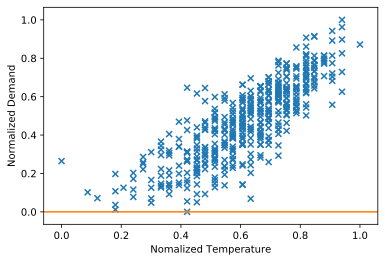

In [60]:
plot_fit(gradient_descent(0))

After just one iteration, we already start to see the line becoming a better fit.

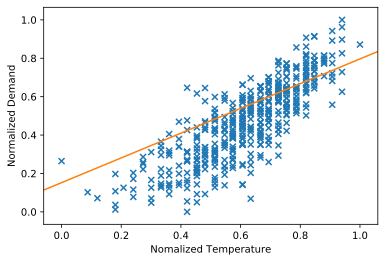

In [61]:
plot_fit(gradient_descent(1))

After five iterations the fit is better still.

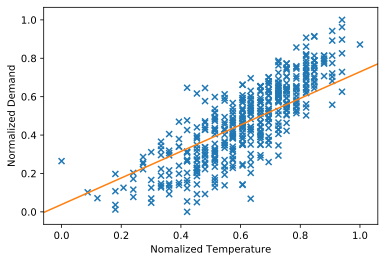

In [62]:
plot_fit(gradient_descent(5))

After 10 iterations.

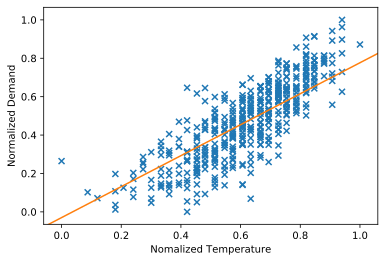

In [63]:
plot_fit(gradient_descent(10))

After 50 iterations.

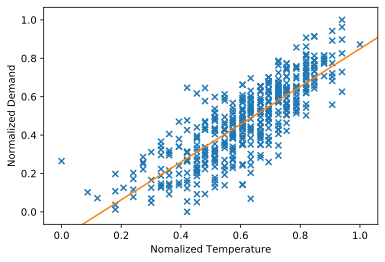

In [64]:
plot_fit(gradient_descent(50))

After 100 iterations

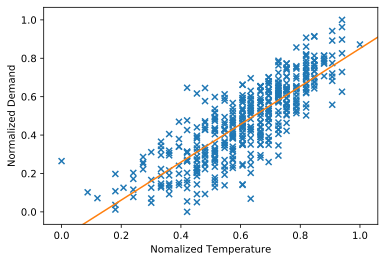

In [65]:
plot_fit(gradient_descent(100))

### Error versus iteration

We can also look at the average error versus iteration.

Text(0, 0.5, 'Average error')

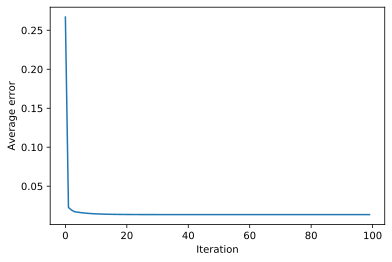

In [66]:
def gradient_descent_err(iters):
    err = []
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        err.append(np.mean((theta[0] * x_nor + theta[1] - y_nor)**2))
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return np.array(err)

plt.plot(np.arange(0,100), gradient_descent_err(100))
plt.xlabel("Iteration")
plt.ylabel("Average error")

Note that because the error decreases so quickly, it's not that easy to see what happens here (which is a good thing, since it means the error effectively gets as low as it can be after 20 iterations or so).  If you want to see a more informative view, though, you can plot, on a log scale, of the error minus the "optimal error" (which you approximate by just running gradient descent a long time).

Text(0, 0.5, 'Average error minus optimal')

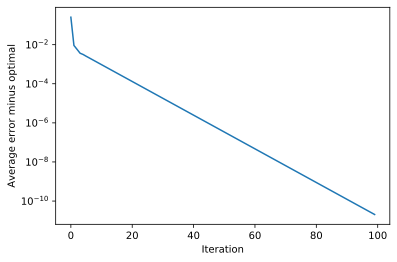

In [67]:
err = gradient_descent_err(1000)
plt.semilogy(err[:100] - err[-1])
plt.xlabel("Iteration")
plt.ylabel("Average error minus optimal")

As you can see, the error is decreasing _linearly_ with iteration number on the log scale; this means we will reach an optimal setting to numerical precision pretty quickly.  Although we won't cover it in any much more here, this is actually a property of the squared error, and things look a bit different if you consider other errors.

### Visualizing parameter updates

As a final visualization, let's look at what with the gradient updates in parameters space.  Here we're going to overlay "level sets" of the objective function (points at which the objective has equal value), the only point of which here is the fact that the optimal setting of these weights is in the "center" of the ellipses; essentially, the objective here is a 3D bowl-shaped function, with the lines showing its contours in 2D.

In [68]:
def gradient_descent_params(iters):
    thetas = []
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        thetas.append(theta.copy())
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return np.array(thetas)

def err(theta):
    return np.mean((np.outer(x_nor, theta[:,0]) + theta[:,1] - y_nor[:,None])**2,axis=0)

Text(0, 0.5, 'theta2')

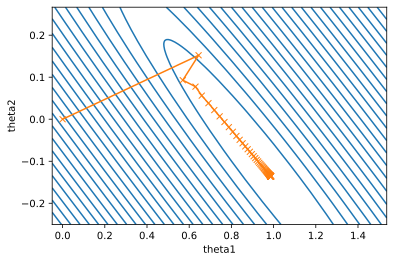

In [69]:
thetas = gradient_descent_params(100)
plt.plot(thetas[:,0], thetas[:,1])
xlim, ylim =(np.array(plt.gca().get_xlim()), np.array(plt.gca().get_ylim()))
xlim += np.array([0,0.5])
ylim += np.array([-0.1, 0.1])

XX,YY = np.meshgrid(np.linspace(xlim[0],xlim[1],200), np.linspace(ylim[0], ylim[1],200))
ZZ = err(np.hstack([np.ravel(XX)[:,None], np.ravel(YY)[:,None]])).reshape(XX.shape)
#V = np.logspace(np.log(np.min(ZZ)), np.log(np.max(ZZ)), 30)
V = np.linspace(np.sqrt(np.min(ZZ)), np.sqrt(np.max(ZZ)), 25)**2
plt.clf()
plt.contour(XX,YY,ZZ, V, colors=('C0',))
plt.plot(thetas[:,0], thetas[:,1], 'C1-x')
plt.xlabel("theta1")
plt.ylabel("theta2")

### Omitting normalization

What happens if we run this same process without first normalizing the data?  Let's look.

In [70]:
def gradient_descent_unnor(iters, alpha=1.0):
    theta = np.array([0., 0.])
    for t in range(iters):
        if t % (iters//10) == 0:
            print("Iteration {:3d}: ".format(t), theta)
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x + theta[1] - y)*x)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x + theta[1] - y) )
    return theta

In [71]:
gradient_descent_unnor(100, alpha=1.0);

Iteration   0:  [0. 0.]
Iteration  10:  [ 3.51102534e+39 -5.65122865e+41]
Iteration  20:  [ 4.45750082e+80 -7.17464384e+82]
Iteration  30:  [ 5.65911995e+121 -9.10872971e+123]
Iteration  40:  [ 7.18466243e+162 -1.15641917e+165]
Iteration  50:  [ 9.12144903e+203 -1.46815785e+206]
Iteration  60:  [ 1.15803398e+245 -1.86393266e+247]
Iteration  70:  [ 1.47020797e+286 -2.36639744e+288]
Iteration  80:  [nan nan]
Iteration  90:  [nan nan]


/Users/kenechidukor/kene_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/kenechidukor/kene_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  


Our parameters start blowing up and quickly cause numerical overflow.  The issue here is that `alpha` is too large for these unscaled values.  So let's lower it a bit.  The following was the lowest value I could find that didn't cause `alpha` to diverge.

In [72]:
gradient_descent_unnor(100, alpha=0.0001);

Iteration   0:  [0. 0.]
Iteration  10:  [ 0.02739216 -0.00011402]
Iteration  20:  [ 0.02739247 -0.00012586]
Iteration  30:  [ 0.02739262 -0.0001377 ]
Iteration  40:  [ 0.02739277 -0.00014954]
Iteration  50:  [ 0.02739291 -0.00016137]
Iteration  60:  [ 0.02739306 -0.00017321]
Iteration  70:  [ 0.02739321 -0.00018505]
Iteration  80:  [ 0.02739335 -0.00019688]
Iteration  90:  [ 0.0273935  -0.00020872]


The problem here is that we are nowhere _near_ converged to the solution.  Let's run it for one million iterations instead.

In [73]:
gradient_descent_unnor(1000000, alpha=0.0001);

Iteration   0:  [0. 0.]
Iteration 100000:  [ 0.02878932 -0.11308122]
Iteration 200000:  [ 0.03006112 -0.2159247 ]
Iteration 300000:  [ 0.03121883 -0.30954191]
Iteration 400000:  [ 0.03227267 -0.39476056]
Iteration 500000:  [ 0.03323197 -0.47233409]
Iteration 600000:  [ 0.03410521 -0.54294836]
Iteration 700000:  [ 0.03490012 -0.6072277 ]
Iteration 800000:  [ 0.03562371 -0.66574043]
Iteration 900000:  [ 0.03628238 -0.71900388]


One million iterations, and our parameters are still changing quite a bit.  What's happening here, as mentioned above, is that we effectively need very different step sizes in the two parameters, because the scales are so different; what is more, it's actually the case that the best choice of parameters are also highly correlated, so that for instance, for a slight change in slope there is a _very_ different choice of intercept that is optimal, and vice versa.  Taken together, this means that it is very difficult for gradient descent to find a "good" direction by which to improve the function, and we essentially have to take extremely small steps that take a very long time for us to reach the optimal value.

### Getting the answer back in the original coordinates

Fortunately, we don't need to resort to solving the system in the original coordinates, we can simply solve on our normalized data and then find the corresponding equations for the original data.  Specifically, since our model gives the approximation
\begin{equation}
\begin{split}
\tilde{y} & \approx \tilde{x} \cdot \theta_1 + \theta_2\\
\Longrightarrow \;\; \frac{y-a}{b} & \approx \frac{x-c}{d} \cdot \theta_1 + \theta_2 \\
\Longrightarrow \;\; y-a & \approx (x-c) \cdot(b \theta_1/d) + b \theta_2 \\
\Longrightarrow \;\; y & \approx x \cdot (b \theta_1/d) + b \theta_2 + a - c b \theta_1/d\\
\Longrightarrow \;\; y & \approx x \cdot \hat{\theta}_1 + \hat{\theta}_2\\
\end{split}
\end{equation}
where
\begin{equation}
a = \min_i y^{(i)}, \;\; b = \max_i y^{(i)} - \min_i y^{(i)}, \;\; c = \min_i x^{(i)}, \;\; d = \max_i x^{(i)} - \min_i x^{(i)}, 
\end{equation}
and where we define
\begin{equation}
\begin{split}
\hat{\theta}_1 & = b \theta_1/d \\
\hat{\theta}_2 & = b \theta_2 + a - c \cdot(b \theta_1/d).
\end{split}
\end{equation}
That might seem like a lot, but all it's saying is that there is an easy formula to convert between the solution we get for the normalized data and the unnormalized data.


In [74]:
theta = gradient_descent(100)
a, b, c, d = min(y), max(y) - min(y), min(x), max(x) - min(x)
theta_hat = np.array([b * theta[0] / d, b*theta[1] + a - c*b*theta[0]/d])

Text(0, 0.5, 'Peak Demand (GW)')

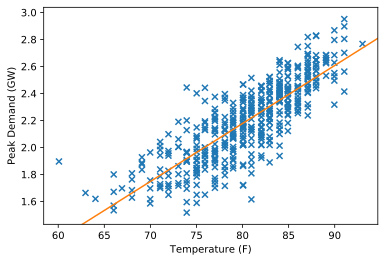

In [75]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta_hat[0]*xlim[0]+theta_hat[1], theta_hat[0]*xlim[1]+theta_hat[1]], 'C1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

The plot of course looks identical to the one we had one the normalized data.  But now we can use the model to make predictions on new data point in terms of the original units, without normalization.  

## Machine learning in general

There was a lot to this example, including collecting the data, deriving the gradient, running the gradient descent algorithm, and considering different aspects of normalization.  We put them before the "general" discussion on ML because these topics are ones that you are absolutely going to encounter in practice (and least the understanding of the models, data normalization, etc, even if you don't end up writing your own gradient descent code).  But the nice aspects now, is that we can introduce virtually all the main concepts the machine learning, hopefully made substantially more concrete by the example.

To define machine learning is more general terms, we're going to first introduce some terminology.  The following elements form the foundation for mathematically defining machine learning algorithms.  We're going to define these in general terms first, but then we will see how they map on to the example in the previous section.

- **Inputs (features):** $x^{(i)} \in \mathbb{R}^n, \; i=1,\ldots, m$ <br/> Inputs, or features, are the information fed into the machine learning algorithm.  The notation here will be important, as we will refer to it frequently: each $x^{(i)}$ an $n$-dimensional vector, and there are $m$ such vectors total.  Note that while outputs in machine learning algorithms, discussed next, can be of different types (discrete, continuous, multivariate), we typically will always represent the input as a real-valued vector.
- **Outputs:** $y^{(i)} \in \mathcal{Y}, \; i=1,\ldots,m$  <br/> Outputs in a machine learning setting are quantities in some set $\mathcal{Y}$, denoting the output space.  Common output spaces will be real-valued scalars (for regression tasks), or binary or multivariate discrete quantities (for classification tasks).
- **Parameters:** $\theta \in \mathbb{R}^d$. <br/> Parameters of a machine learning algorithm are the numbers that define our prediction function.  They are the elements that we will optimize to make the prediction as good as possible.
- **Hypothesis function:** $h_\theta : \mathbb{R}^n \rightarrow \hat{\mathcal{Y}}$  <br/> A hypothesis funtion is a mapping from the input space $\mathbb{R}^n$ to the _prediction space_ $\hat{\mathcal{Y}}$.  Note that the prediction space is not necessarily the same as the output space $\mathcal{Y}$, but it represents quantities that can easily be transformed to the output space.  This distinction is a bit tricky, and in the case of the the regression task we describe in these notes, it is not relevant: in this task, both the output and prediction spaces are simply the real numbers $\mathbb{R}$.  But it will be relevant in the next set of notes, when we discuss classification, so we introduce more general terminology here.  Also note that the hypothesis function is really also a function of $\theta$, as these parameters dictate how the function makes its predictions; but from a notational standpoint we'll write $h_\theta(x)$ rather than $h(\theta,x)$ because we want to emphsize that the hypothesis function serves essentially as a mapping from inputs to outputs.
- **Loss function:** $\ell : \hat{\mathcal{Y}} \times \mathcal{Y} \rightarrow \mathbb{R}\_+$ <br/> Finally, a loss function  (a mapping from predictions and true outputs to positive real numbers, is a measure of how good a prediction is.  If the prediction is "close" to the true output, we want this quantity to be small, whereas if it is far away, we want to the quantity to be large.  We will typically write the loss function as $\ell(h_\theta(x),y)$ to denote the fact that its first argument is the prediction and its second argument is the output.

### The canonical machine learning problem

With this ingredients defined we can, believe it or not, write down just about _every_ (supervised) machine learning algorithm that exists in the following canonical form: _the goal of any machine learning algorithm is to find the parameters that minimize the average of losses on the data._  This problem is written formally as 
\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_\theta \; \frac{1}{m}\sum_{i=1}^m \ell(h_\theta(x^{(i)}, y^{(i)}) \;\; \equiv \;\; \minimize_\theta \; E(\theta)
\end{equation}
(i.e., minimize the average loss between the prediction and actual output, evaluated over all $m$ data points, which we will denote generally as $E(\theta)$).  Thus, to formally define any particular learning algorithm, we just need to specify three different elements:

1. What is the form of the hypothesis function $h_\theta$?
2. What is the loss function $\ell$?
3. How do we solve the optimization problem of minimizing the sum of losses?

These three elements (in different forms, of course), make up the entirety of all supervised machine learning approaches.  Unfortunately, what is very confusing about machine learning algorithms, when you read about them for the first time, is that these elements are not always made clear at all.  Rather, the formal justification behind the algorithm (e.g., a probabilistic or geometric set of rationales) take center stage, and it is difficult to view the algorithm in this simple context above.  What is worse, often times a particular "algorithm" will only specify some of the elements above, and leave others undefined.  Or there may be _mutiple_ different answers to one of the questions, while people still refer to the algorithm by the same name.  But as you encounter new machine learning algorithms, it will be helpful to continually put them into this context, as much as possible (it will help to demystify many of the algorithms, and make you understand better how they all relate to each other)  

To give a preview of what is to come, we're going to list a few names of common machine learning algorithms you may have heard about previously (and we're going to discuss each of these in the course ... of course there are many others that we won't discuss).  This is also not quite a perfect breakdown, but it captures the main ideas of each of the following approaches.

| Algorithm | Hypothesis | Loss | Optimization method |
| :---: | :---: | :---: | :---: | :---: |
| Least squares | Linear | Squared error | (Usually) analytic solution |
| Linear regression | Linear | _Any regression loss_ | _Any_ |
| Support vector machine | Linear or kernel | Hinge loss | _Any_ |
| Logistic regression | (Usually) linear | Logistic loss | _Any_ |
| Neural network | Composed non-linear function | _Any_ | (Usually) gradient descent variant |
| Decision tree | Axis-aligned halfplanes | Log probability under bernoulli model | Greedy search |
| Naive Bayes | Linear | Joint probability of data and output | Analytic solution |
| Gradient boosting | Ensemble of other models (usually decision trees) | _Any_ | Gradient descent |



### Instantiation on demand forecasting setting

Let's make all this a bit more concrete by considering how we apply this framework to the example from the previous section.  In our demand forecasting task, we had

- Inputs: $x^{(i)} \in \mathbb{R} = \mathrm{HighTemperature}^{(i)}$.  The input was just a one-dimensional input that included just the high temperature for day $i$.
- Output: $y^{(i)} \in \mathbb{R} = \mathrm{PeakDemand}^{(i)}$. The output was a one-dimensional real value corresponding to the peak demand for that day.
- Parameters: $\theta \in \mathbb{R}^2$. The parametesr were to real numbers that captured the slope and intercept of the model.
- Hypothesis: $h_\theta : \mathbb{R} \rightarrow \mathbb{R}$, $h_\theta(x) = \theta_1 x + \theta_2$.  The hypothesis here was just a linear function mapping inputs to real numbers (so here the prediction space is also $\mathbb{R}$, just like the output space).
- Loss: $\ell : \mathbb{R} \times \mathbb{R} \rightarrow \mathbb{R}_+$, $\ell(h_\theta(x), y) = (h_\theta(x) - y)^2$.  The loss function here is simply the squared error between the prediction and output, both of which are scalar real-valued quantities.

Thus, the machine learning problem in question, which of course exactly matches what we had defined above, is given by the optimization problem
\begin{equation}
\minimize_\theta \; \frac{1}{m} \sum_{i=1}^m \ell(h_\theta(x^{(i)}, y^{(i)}) \;\; \equiv \;\; 
\minimize_\theta \; \frac{1}{m} \sum_{i=1}^m (\theta_1 x^{(i)} + \theta_2 - y^{(i)})^2
\end{equation}

Thus, we have defined the first two elements of the machine learning algorithm: the hypothesis function and the loss function.  All that remains is to specify how we solve the optimization problem, which in the case above was accomplished via gradient descent.  Thus, the peak demand forecasting example is a straightforward instantiation of each of the three elements of a machine learning algorithm.

## Least squares revisited

With a more formal framework is place for describing machine learning algorithms, let's revisit the least squares algorithm we considered above, but in a more general case.  For instance, what if we wanted to add additional features to our prediction instead of just the temperature?  What if we wanted to use a loss function other than the squared loss?  What if we wanted to use a non-linear instead of a linear hypothesis function?  Some of these questions we will defer to later lectures, but we here will present a more general form of least squares regression that can apply generically to a wide range of regression problems.

Before we define the main elements of the least-squares problem, let's make one change for notational convenience, and introduce a _constant feature_ into our feature vector. For example, instead of just having $x^{(i)} = \mathrm{HighTemperature}^{(i)}$, we can have
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)}\\ 1 \end{array} \right ]
\end{equation}
i.e., we just append a constant to our inputs and call this the new input the algorithm.  We can of course also have additional inputs, which we will see shortly, such as
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} \mathrm{HighTemperature}^{(i)}\\ \mathrm{IsWeekday}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
but the point is that we will always have a constant term 1 be the final feature.  The reason for doing so is that now we can use the simple linear hypothesis with $\theta \in \mathbb{R}^n$ and 
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x.
\end{equation}
Because the final feature is always one, the final coefficient $\theta_n$ always serves as a bias term without the need for special handling.  This ultimately makes for a cleaner formulation of most algorithms, so we will generally adopt this notation throughout.

Now let's define the key ingredients of the least square problem.  Note that these are exactly the same as we had in our previous example, except that we now have a more generic form of hypothesis function.

1. Linear hypothesis function $h_\theta(x) = \sum_{j=1}^n \theta_j x_j$.
2. Squared error loss: $\ell(h_\theta(x), y) = (h_\theta(x) - y)^2$

These specify the first two elements of a machine learning algorithm, but how do we solve the resulting machine learning optimization problem
\begin{equation}
\minimize_\theta \;\; \frac{1}{m} \sum_{i=1}^m \left (\sum_{j=1}^n \theta_j x^{(i)}_j - y^{(i)} \right )^2
\end{equation}
where we will again use $E(\theta)$ as shorthand for this objective.

In this section, we'll explore two ways to do so, by gradient descent, generalizing the procedure we described earlier, and by exact solution.

### Gradient descent for least squares

Recall that the gradient descent algorithm takes a small step in the direction of the negative partial derivative for each coordinate of the parameters $\theta_j$.  So to being, let's take the partial derivative of the objective with respect to $\theta_j$.  Again, the only properties were are going to use here are the chain rule, linearity of derivatives, and simple rules for differentiating polynomials.  Note also that because we are differentiating with respect to $\theta_j$, we'll use the index $k$ to sum over the different coordinates in the hypothesis function, or else there would be a collision with too many $j$ variables.
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_j} 
& = \frac{\partial}{\partial \theta_j} \frac{1}{m}\sum_{i=1}^m \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  \frac{\partial}{\partial \theta_j} \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m 2 \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) \frac{\partial}{\partial \theta_j} \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) \\
& = \frac{2}{m} \sum_{i=1}^m \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) x^{(i)}_j \\
\end{split}
\end{equation}
where the key observation in moving from like 3 to 4 is that when we differentiate $\sum_{k=1}^n \theta_k x^{(i)}_k$ with repsect to $\theta_j$, this term will only be a non-constant relative to $\theta_j$ with $j=k$, in which case the derivative is just the $x^{(i)}_j$ term.

Thus, gradient descent for the least squares algorithm takes the following form

<hr/>

**Initialize:**
    
* $\theta := 0$ 

**Repeat until converged:**

* **For $j = 1,\ldots,n$:**

    * $\displaystyle \theta_j := \theta_j + \alpha\frac{2}{m} \sum_{i=1}^m \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) x^{(i)}_j$

<hr/>

Let's see how this looks is code.  It's important to emphasize that this is _not_ an efficient implementation of gradient descent: it uses for loops extensively to illustrate the concepts behind the algorithm, but can be sped up significantly by using matrix/vector routines.  Nonetheless, it does do some of the "obvious" optimizations, such as caching each prediction before iterating over the elements in the gradient.

In [76]:
def gradient_descent_ls(X, y, iters, alpha=1.0):
    m, n = X.shape
    theta = np.zeros(n)
    errs = np.zeros(iters)

    for t in range(iters):
        grad = np.zeros(n)
        for i in range(m):
            yhat = X[i] @ theta
            errs[t] += 1/m * (yhat - y[i])**2
            for j in range(n):
                grad[j] += 1/m * 2 * (yhat - y[i])*X[i,j]
        theta -= alpha * grad
    return theta, errs

### Evaluation on peak demand forecasting

Let's see how this function works in practice.  To do so, we're going to cosider adding the additional feature we mentioned above, a flag of whether or not the day is a weekday or weekend.  To get a sense of what this data looks like, we can visualize the same data as above, but also plot the additional feature indicating whether or not the data is a weekday.

In [77]:
# add the weekday column to our data frame
import datetime
weekday = list(map(lambda x : datetime.datetime.strptime(x, "%Y%m%d").weekday() <= 4, df_summer.index))
df_summer.loc[:,"IsWeekday"] = weekday

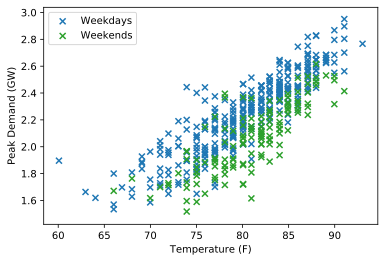

In [78]:
plt.scatter(df_summer[df_summer["IsWeekday"]==True]["Temp"], 
            df_summer[df_summer["IsWeekday"]==True]["Load"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["Temp"], 
            df_summer[df_summer["IsWeekday"]==False]["Load"], marker='x', color='C2')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.legend(["Weekdays", "Weekends"])

As illustrated in the figure, viewed this way it is clear that, on average, the peak electricity consumption is higher on the weekedays than the weekends.  Plots like this help indicate that this is a useful feature to consider: variability in the output that previously just looked like noise (i.e., the fact that for a given temperature, there was a high range of possible peak demands), can be explained to some degree by this additional features.  Thus, in addition to an illustration of a more general least squares procedure, this example also illustrates some of the fundamental goals of _feature engineering_: we can construct a feature that "explains" some of the errors that our original model makes.  We will discuss feature engineering much more later in this course, but this type of visual analysis will prove extremely useful when evaluating new potential features.

Let's also create a normalized data set for our new least squares prediction problem.  Note that when normalizing data we obviously _can't_ normalize the all-ones column, but you do typically want to normalize the remaining columns (in this particular case, it won't do anything to the "IsWeekday" column, because there the min and max are already 0 and 1), but we provide the code to do so just for illustration purposes.

In [79]:
def normalize_data(X, y, normalize_cols):
    """ Normalize y and specified columns of X in place. """
    min_X = X[:,normalize_cols].min(axis=0)
    max_X = X[:,normalize_cols].max(axis=0)
    min_y = y.min()
    max_y = y.max()
    X[:,normalize_cols] = (X[:,normalize_cols] - min_X) / (max_X - min_X)
    y[:] = (y - min_y) / (max_y - min_y)
    return min_X, max_X, min_y, max_y

# normalize X and y
X = np.array([df_summer["Temp"], df_summer["IsWeekday"].astype(float), np.ones(len(df_summer))]).T
y = df_summer["Load"].values.copy()
ranges = normalize_data(X, y, [True, True, False])

Now let's run gradient descent to find our parameters, and convert them back into units in the original problem.  Note that in general, the method for unnormalizing the parameters is a simple extension of what we described before.  Specifically, if
\begin{equation}
\frac{y-\min(y)}{\mathrm{range}(y)} = \sum_{j=1}^{n-1} \theta_j \frac{x_j - \min(x_j)}{\mathrm{range}(x_j)} + \theta_n
\end{equation}
then 
\begin{equation}
y = \sum_{j=1}^{n-1}\hat{\theta}_j x_j + \hat{\theta}_n
\end{equation}
where 
\begin{equation}
\hat{\theta}_j = \theta_j \frac{\mathrm{range}(y)}{\mathrm{range}(x_j)}, \;\; \hat{\theta}_n = \theta_n \mathrm{range}(y) + \min(y) - \sum_{j=1}^{n-1} \hat{\theta}_j \min(x_j).
\end{equation}

In [80]:
def unnormalize_theta(theta, normalize_cols, ranges):
    theta[normalize_cols] /= (ranges[1] - ranges[0])
    theta *= ranges[3] - ranges[2]
    theta[-1] += ranges[2] - theta[normalize_cols] @ ranges[0]

theta, errs = gradient_descent_ls(X, y, 500, alpha=0.5)
unnormalize_theta(theta, [True, True, False], ranges)
print(theta)

[ 0.04373337  0.20337511 -1.46624764]


Finally, we can visualize the model fit by plotting the resulting predictions for both the weekend and weekday cases.

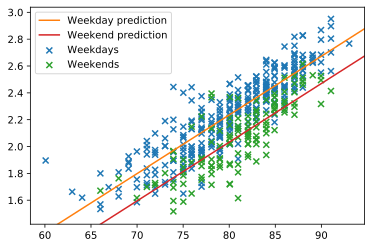

In [81]:
plt.scatter(df_summer[df_summer["IsWeekday"]==True]["Temp"], 
            df_summer[df_summer["IsWeekday"]==True]["Load"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["Temp"], 
            df_summer[df_summer["IsWeekday"]==False]["Load"], marker='x', color='C2')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta[0]*xlim[0] + theta[1] + theta[2], theta[0]*xlim[1] + theta[1] + theta[2]], 'C1',
         xlim, [theta[0]*xlim[0] + theta[2], theta[0]*xlim[1] + theta[2]], 'C3')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(["Weekday prediction", "Weekend prediction", "Weekdays", "Weekends"])

### Analytic solution

Gradient descent is appealing in its generality but certainly also has some annoyances (picking step sizes, number of iterations, ensuring proper data normalization, etc).  These issues will be unavoidable for many of the problems we encounter, but it turns out that for least squares in particular, there is an alternative that is much easier to compute in many cases.  Specifically, if we consider our previous picture on the derivative of a function
![Illustration of a function and it's derivative.](opt_grad.svg)
then we can see that the derivative doesn't just point is the direction of function increase, it also provides a method for checking whether the solution is optimal: namely, a point will be at a minimum precisely when the gradient is zero (in general, a zero derivative could mean either a minimum or a maximum, but it turns out for the types of functions such as the least squares objective, there is only a single global minimum that has zero derivatives).  In the case of multivariate functions, the condition is similar: a function (assuming some technical conditions, such that it is differentiable everywhere) will be at a minimum only if all the partial derivatives are zero.

To make the notation a bit more convenient, we introduce an additional term called the _gradient_ of a function.  For a function $f : \mathbb{R}^n \rightarrow \mathbb{R}$, the gradient, denoted $\nabla f(\theta)$, is a vector of all partial derivatives
\begin{equation}
\nabla f(\theta) \in \mathbb{R}^n = \left [ \begin{array}{c} 
\displaystyle \frac{\partial f(\theta)}{\partial \theta_1} \\
\displaystyle \frac{\partial f(\theta)}{\partial \theta_2} \\ \displaystyle \vdots \\
\displaystyle \frac{\partial f(\theta)}{\partial \theta_n} \end{array} \right ].
\end{equation}
There are a few important things to note here.  First, the gradient as we defined it here is defined only for functions that take _vector_ inputs and output a _scalar_: we cannot take the gradient of a vector-valued function, or a matrix-input function.  Second, the gradient is itself always a _vector_ the same same as the input to the function.  If there are multiple arguments to the function $f$ e.g., $f(\theta,\eta)$, then we will indicate which element we take the gradient with respect to using the notation $\nabla_\theta f(\theta,\eta)$, but we can omit this subscript in the case that there is only one specified argument to the function.

Restating what we said above with this notation, the condition that $f(\theta)$ be at a minimum holds only if $\nabla f(\theta) = 0$.  What is interesting about the least squares case is that we can actually find such a point analytically using matrix operations.

First, let's write the gradient of the least squares objective more succinctly.  Recall from before that we had
\begin{equation}
\frac{\partial E(\theta)}{\partial \theta_j} = \frac{2}{m} \sum_{i=1}^m \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ) x^{(i)}_j
\end{equation}
Since the only term here that depends on $j$ is the final $x^{(i)}_j$, this immediately leads to the fact that
\begin{equation}
\nabla E(\theta) = \frac{2}{m} \sum_{i=1}^m x^{(i)} \left (\sum_{k=1}^n \theta_k x^{(i)}_k - y^{(i)} \right ).
\end{equation}

Let's use the fact that $\sum_{k=1}^n \theta_k x_k \equiv \theta^T x = x^T \theta$ to write this a bit more succintly as
\begin{equation}
\begin{split}
\nabla E(\theta) & = \frac{2}{m} \sum_{i=1}^m x^{(i)} \left ({x^{(i)}}^T \theta - y^{(i)} \right ) \\
& = \frac{2}{m} \sum_{i=1}^m x^{(i)} {x^{(i)}}^T \theta -  \frac{2}{m} \sum_{i=1}^m x^{(i)} y^{(i)} \\
& = \frac{2}{m} \left(\sum_{i=1}^m x^{(i)} {x^{(i)}}^T \right) \theta -  \frac{2}{m} \sum_{i=1}^m x^{(i)} y^{(i)}
\end{split}
\end{equation}
where in both lines we used the distributive property of matrix multiplication and in the last line, the fact that $\theta$ does not depend on $i$. Now, we can find the $\theta^\star$ that makes this entire term zero just with some linear algebra.
\begin{equation}
\begin{split}
\nabla E(\theta^\star) = 0 & \Longleftrightarrow 
 \frac{2}{m} \left(\sum_{i=1}^m x^{(i)} {x^{(i)}}^T \right) \theta^\star -  \frac{2}{m} \sum_{i=1}^m x^{(i)} y^{(i)} = 0 \\
 & \Longleftrightarrow \theta^\star = \left(\sum_{i=1}^m x^{(i)} {x^{(i)}}^T \right)^{-1} \left (\sum_{i=1}^m x^{(i)} y^{(i)} \right )
 \end{split}
\end{equation}
where note that the $\frac{2}{m}$ terms will cancel, leading to the final solution without any additional constant term.

If expressions like this seems hard to follow at first, a good strategy is to determine the size of each element of the expression.  For example, what size is the (matrix? vector?) $\sum_{i=1}^m x^{(i)} {x^{(i)}}^T$?  What size is the (matrix? vector?) $\sum_{i=1}^m x^{(i)} y^{(i)}$?  Going through these questions yourself, just using the definitions of matrix multiplication, will help make the algorithms that follow much more concrete.

Let's see what this looks like in code.  The following code will compute the $\sum_{i=1}^m x^{(i)} {x^{(i)}}^T$ (denoted `A` in the code) and $\sum_{i=1}^m x^{(i)} y^{(i)}$ (denoted `b` in the code) terms, and compute the solution this this equation using the `np.linalg.solve()` function.  Note that here and below, we will assume that the inverse we form exists, though in a few lectures we will discuss ways to overcome this issue in the case that the term is not invertible.

In [82]:
def analytic_ls(X,y):
    m,n = X.shape
    A = np.zeros((n,n))
    b = np.zeros(n)
    for i in range(m):
        A += np.outer(X[i], X[i])
        b += X[i] * y[i]
    return np.linalg.solve(A, b)

Let's apply this function to the (unnormalized) data above.

In [83]:
X = np.array([df_summer["Temp"], df_summer["IsWeekday"].astype(float), np.ones(len(df_summer))]).T
y = df_summer["Load"].values.copy()
theta = analytic_ls(X,y)
print(theta)

[ 0.04373511  0.20337914 -1.46639085]


We get the same answer as with gradient descent, but with no need for an iterative method or picking stepsize parameters.  However, it turns out we can make the code even simpler by writing even more of the terms in linear algebra form.

### Matrix/vector notation: one more level

To make the least squares solutione even simpler (and remember, this _is_ about making the resulting method simpler ... even if it seems more complex due to the initial notation, the simplicity will hopefully come through in the final code that we write), we can introduce some additional matrix/vector notation.  First, let's define the matrix and vector
\begin{equation}
X \in \mathbb{R}^{m \times n} = \left [ \begin{array}{c} 
{x^{(1)}}^T \\
{x^{(2)}}^T \\
\vdots \\
{x^{(m)}}^T \end{array} \right ], \;\;
y \in \mathbb{R}^{m} = \left [ \begin{array}{c} 
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m)} \end{array} \right ],
\end{equation}
i.e., $X$ is a matrix with the individual inputs as the _rows_ in the matrix, and $y$ is a vector of all the outputs. 
Note that these are actually exactly the matrix/vector we already formed for our data in the code above, so this is a fairly natural representation.

Let's now consider how to succintly represent the term 
\begin{equation}
\nabla E(\theta) = \frac{2}{m} \sum_{i=1}^m x^{(i)} \left ({x^{(i)}}^T \theta - y^{(i)} \right )
\end{equation}
using this notation.  First, note that the vector $X \theta - y$ (an $m$ dimenional vector), contains precisely ${x^{(i)}}^T \theta - y^{(i)}$ as its $i$th element.  So to create a new vector that multiplies $x^{(i)}$ by each element of this vector, we simply form the matrix-vector product
\begin{equation}
\nabla E(\theta) = \frac{2}{m} X^T (X \theta - y).
\end{equation}

This formula both provides a convenient way to compute the entire gradient (we could replace the notation code in the previous sections that computes the gradient with this expression, to avoid any for loops), and it provides a succint way to compute the analytic solution.
\begin{equation}
\nabla E(\theta^\star) = 0 \; \Longleftrightarrow \; \frac{2}{m} X^T (X \theta^\star - y) = 0 \; \Longleftrightarrow \theta^\star = (X^T X)^{-1} X^T y.
\end{equation}

Let's see what this looks like in code.

In [84]:
theta = np.linalg.solve(X.T @ X, X.T @ y)
print(theta)

[ 0.04373511  0.20337914 -1.46639085]


In a single line of code, we can compute the exact solution to this machine learning optimization problem.

### Alternative loss functions

Although this section properly doesn't belong here, given that the heading of this section is explictly "Least squares", it is worth considering what happens if we want to optimize some alternative loss function.  For example, what if we define the loss to be the absolute loss rather than the squared loss
\begin{equation}
\ell(h_\theta(x),y) = |h_\theta(x) - y|.
\end{equation}
This is a perfectly reasonable way to measure error (perhaps even more intuitive than squared error).  And the nice thing about the generic machine learning framework we have discussed is that we can essentially leave all other elements of the problem setup unchanged and just change the loss function.

Unfortunately, for the absolute loss, there is no longer a closed-form solution for the optimal $\theta$ (indeed, the existence of a closed-form solution is one of the reasons _why_ the squared loss is so popular), so we must revert back to gradient descent for solving the optimization problem, which is now given by
\begin{equation}
\minimize_\theta \; \frac{1}{m} \sum_{i=1}^m |h_\theta(x^{(i)}) - y^{(i)}|.
\end{equation}
This objective is sometimes refered to a the _mean absolute error_, and the resulting algorithm is often referred to as _robust regression_.  The name robust regression comes from the fact that the method is inherrently less succeptible to "outliers" than the least squares loss.  This is because making an "very incorrect" prediction will only lead to a penalty of the magnitude of that prediction, whereas in least squares, it will penalize according to the _squared_ magnitude (which grows much more quickly).  Because of this, the least squares solution can be heavily affected by single outliers, i.e., the resulting theta will be substantially different in response to a single bad point.  Robust regression, using the absolute error, does not have this problem.

Noting that the derivative of the absolute value is simply given by the sign of the inner quantity (technically speaking, this is an element in the subdifferential, beause the absolute value is not differentiable at zero, but we can ignore this fact and just continue with the gradient descent procedure as before, noting that it is actually now called "subgradient descent" if you want to be precise), the (sub)gradient of the objective is given by
\begin{equation}
\nabla E(\theta) = \frac{1}{m} \sum_{i=1}^m x^{(i)} \mathrm{sign}({x^{(i)}}^T \theta - y^{(i)}) \equiv \frac{1}{m} X^T \mathrm{sign}(X \theta - y)
\end{equation}
where in the last equation we note that this refers to the $\mathrm{sign}$ function applied elementwise to the vector $X\theta - y$.  The following code thus implements gradient descent for the robust regression formulation.

In [85]:
def gradient_descent_rr(X, y, iters, alpha=1.0):
    m, n = X.shape
    theta = np.zeros(n)
    errs = np.zeros(iters)

    for t in range(iters):
        yhat = X @ theta - y
        errs[t] = np.mean(np.abs(yhat))
        grad = (1/m) * X.T @ np.sign(yhat)
        theta -= alpha * grad
    return theta, errs

In [86]:
# normalize X and y
X = np.array([df_summer["Temp"], df_summer["IsWeekday"].astype(float), np.ones(len(df_summer))]).T
y = df_summer["Load"].values.copy()
ranges = normalize_data(X, y, [True, True, False])

In [87]:
theta,errs = gradient_descent_rr(X,y,500, 0.1)
unnormalize_theta(theta, [True, True, False], ranges)
print(theta)

[ 0.04491061  0.19639565 -1.55874553]


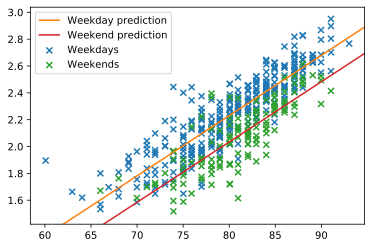

In [88]:
plt.scatter(df_summer[df_summer["IsWeekday"]==True]["Temp"], 
            df_summer[df_summer["IsWeekday"]==True]["Load"], marker='x', color='C0')
plt.scatter(df_summer[df_summer["IsWeekday"]==False]["Temp"], 
            df_summer[df_summer["IsWeekday"]==False]["Load"], marker='x', color='C2')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta[0]*xlim[0] + theta[1] + theta[2], theta[0]*xlim[1] + theta[1] + theta[2]], 'C1',
         xlim, [theta[0]*xlim[0] + theta[2], theta[0]*xlim[1] + theta[2]], 'C3')
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(["Weekday prediction", "Weekend prediction", "Weekdays", "Weekends"])

If you really squint at this figure and the above one for least squares, you will see that they do differ slightly (you can also see that the parameters themselves do differ).  However, the difference here is not very instructive.  This is because, as a linear fit gets better and better, virtually all loss functions become "equivalent". For example, consider the case where the data lies exactly on a line; then both loss functions will give the exact same result, namely fitting that line exactly.  Thus, for cases like the above, where a line fits the data quite well, we don't expect to see a huge difference between different loss functions  This is not the case, though, for settings where we do have high error, especially with a large number of outlier points, for the reasons mentioned before.



## Libraries for machine learning in Python

Finally, we conclude with some information about the types of libraries we will use to run machine learning algorithms in Python.  Although there are a number of machine learning packages available, by far the most popular Python library for general-purpose "classical" machine learning (this is in contrast to packages focused specficially on deep learning, such as [TensorFlow](http://www.tensorflow.org)) is the [scikit-learn](http://scikit-learn.org/) library.  Scikit Learn is general purpose machine learning library with a number of common machine learning algorithms built in.

One important note, however, is that (despite some ongoing efforts to make it more scalable), scikit-learn is still best suited for small to medium-scale problems (say with ~10,000s of examples and ~1,000s of features).  For these size problems, most of the algorithms contained in the library will work reasonably fast, and the library has the advantage that one can train many different types of algorithms all with the same interface.  However, if you have data that is much bigger than this, then the algorithms start to get fairly slow compared to other more specialized libraries, and you are likely better off using an alternative library.

Another important caveat, and this is one that sadly often gets ignored, is that unlikely other software libraries, you _need_ to have some (even just basic) understanding of what the algorithms do in order to use scikit-learn effectively.  This is because virtually all algorithms will have some substantial number of hyperparameters, settings to the algorithm that can drastically effect performance (and really, affect _all_ the underlying aspects of the algorithm itself, the hypothesis, loss, and optimization problem).  Sadly, a surprisingly large number of the statements people make about data science techniques seem less about the actual algorithms and more about whatever default settings scikit-learn happens to have for each algorithm.  This is why you get people saying things like "support vector machines worked better than neural networks for this problem", which is a completely meaningless statement unless you know _what sort_ of support vector machine, and _what architecture_ neural network.  Maybe in 10 years we will be at a place where the ML algorithms truly are "self-contained", and practitioners don't need to know anything about the underlying algorithms to get good performance (certainly, some researchers and companies are attempting to develop tools that move in this direction).  But for the vast majority of tasks, we are still a lot ways away from this point, and you do absolutely need to understand the algorithms to get reasonable performance.

### Linear regression in scikit-learn

Let's look at how we specify a model, fit it to data, and make predictions in scikit-learn.  These three tasks form the common usage pattern for most interation with scikit-learn.  Let's first prepare our data.  Note that scikit-learn by default will fit a separate intercept term for linear regression models, so we don't include the all-ones entry in our features.

In [89]:
X = np.array([df_summer["Temp"], df_summer["IsWeekday"]]).T
y = df_summer["Load"].values.copy()

Now we can import and initialize our model.  In general, scikit-learn has a different class for each different type of learning algorithm.  In this case, we are importing the `LinearRegression` class.  When we initialize the class, we pass various parameters to the constructor.  In this case, we are specifying that we _will_ fit an intercept term (i.e., we will _not_ pass it as an explicit feature), and that we will not normalize the data.  These are in fact the default parameters of the linear regression class, but we include them explicitly just for illustration.

In [90]:
# import the model and fit it to data
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, normalize=False)

Note that when we create this class we haven't actually passed any data to the system.  This is the standard interface for scikit-learn classes: the constructor just initializes the hyperparameters of the model, and when we actually want to fit it to data, we call the `model.fit()` function.

In [91]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Finally, when we want to make a prediction on a _new_ data point, we call the `model.predict()` function, passing in the feature values for the new points we want to predict.  In the following example, we would be predicting what the peak demand would be given a 77 degree weekday, and an 80 degree weekend.  Note that we can pass multiple points to predict at once.

In [92]:
# predict on new data
Xnew = np.array([[77, 1], [80, 0]])
print(model.predict(Xnew))

[2.10459141 2.03241758]


Finally, if we want to inspect the internal state of the classifier (i.e., the parameters), we can use the `model.coef_` and `model.intercept_` properties (but, as the names suggest, these are typically considered "private" variables that you don't need to access directly in most cases).

In [93]:
print(model.coef_, model.intercept_)

[0.04373511 0.20337914] -1.4663908512495967


As expected, these are exactly the same values as we got when we computed the least squares solution ourself.

### Scikit-learn vs. pure Python

For an algorithm as simple as least-squares, I highly recommend that you just implement the algorithm youself.  It is literally one line of code to train the model, and you end up with a much better understanding of what is going on.

In [94]:
# create old X that has the intercept terms
X = np.array([df_summer["Temp"], df_summer["IsWeekday"].astype(float), np.ones(len(df_summer))]).T

theta = np.linalg.solve(X.T @ X, X.T @ y)
print(theta)

[ 0.04373511  0.20337914 -1.46639085]


Making predictions is also just one line of code, forming $X \theta$.

In [95]:
Xnew = np.array([[77, 1, 1], [80, 0, 1]])
print(Xnew @ theta)

[2.10459141 2.03241758]


With something so simple, it has always struck me as complete overkill to import an entire library like scikit-learn, especially since you now have to remember things like whether or not to specify the bias term, etc.  You'll have much more control over the algorithm if you just implement it manually.  However, the real advantage of scikit-learn, as mentioned, is that you can very quickly try out a large number of algorithms, so if you do throw least squares in there amongst many others, it is not the worst thing in the world.  Just be aware that nothing magical is happening in the background here, just some very simple linear algebra.